Flow-based entropic regularization for $W_1$ optimal transport
==

This showcase a simple (non sparse) implementation of an approximate $W_1$ solver which penalize the entropy of the flow variables.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import NearestNeighbors

Data generation 
----------------------------------------------------------------

Generate a random planar K-NN graph.

In [9]:
n = 200
X = np.random.rand(2, n)
k = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k).fit(X.T)
distances, indices = nbrs.kneighbors(X.T)
A = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in indices[i]:
        A[i, j] = 1
        A[j, i] = 1  # Ensure the graph is undirected
    A[i, i] = 0

Create create source (>0) and destination (<0) mass vector $z$ with zero total mean.

In [10]:
z = np.zeros(n)
z[np.argmin(X[1]+X[0])] = 1
z[np.argmax(X[1]+X[0])] = -1
p = 1
for _ in range(p): # diffuse a bit on the graph
    z = A@z + z
z = np.sign(z)
z[z>0] = z[z>0]/np.sum(z[z>0]) 
z[z<0] = -z[z<0]/np.sum(z[z<0]) 

Display the graph with source/destination nodes in red/blue

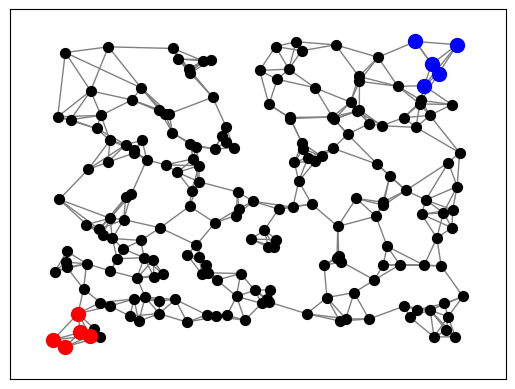

In [21]:
G = nx.from_numpy_array(A)
pos = {k: X[:, k] for k in range(n)}
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z>0)[0], node_color='red', node_size=100)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z<0)[0], node_color='blue', node_size=100)
plt.show()

Linear programming solver
--------------------------------

Solve using CVXPY the linear program:
$$
    \min_{F \in \mathbb{R}_+^{n \times n}} \{ \langle F,W \rangle  \;:\; F^\top 1 - F 1 = z \}. 
$$
The variable $F_{i,j}$ is the flow from node $i$ to node $j$. This is a compact representation which enforces at optimality that either $F_{i,j}$ or $F_{j,i}$ is 0. 

In [12]:
import cvxpy as cp
W = 1 / (A + 1e-6) # make W very large for non-edge (i,j)
F_cp = cp.Variable((n, n), nonneg=True)
ones = np.ones(n)
constraint = [F_cp.T @ ones - F_cp @ ones == z]
objective = cp.Minimize(cp.sum(cp.multiply(F_cp, W)))
problem = cp.Problem(objective, constraint)
problem.solve()
F = F_cp.value

Displays the flow variable on the edges.

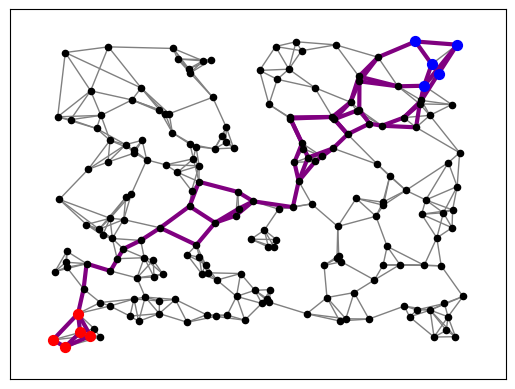

In [20]:
tol = 1e-5
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=20, width=1)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z>0)[0], node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z<0)[0], node_color='blue', node_size=50)
edges_to_draw = [(i, j) for i in range(n) for j in range(n) if F[i, j] > tol]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='purple', width=3, node_size=0)
plt.show()

$W_1$ Sinkhorn
--------------------------------

$W_1$-Sinkhorn's algorithm computes
$$
    f = e^{\frac{-W_{i,j} + h_i - h_j }{\varepsilon} }
$$
with the iterations
$$
    h \longleftarrow \frac{h}{2} - \frac{\varepsilon}{2}  m 
$$
where
$$
    m := \log( \sqrt{ r^2 + a \odot b } + r ) - \log(b)
$$
where we denoted
$$
    a_i := \sum_j e^{\frac{-W_{i,j} - h_i }{\varepsilon} }, \quad
    b_i := \sum_j e^{\frac{-W_{i,j} + h_i }{\varepsilon} }, 
$$ 

In [14]:
import scipy as sp 
def lse(Z,u): return sp.special.logsumexp( Z + u[None,:], axis=1 )
def sinkhown_w1(W,z, epsilon, niter):
    K = np.exp(-W/epsilon )
    h = np.zeros(n)
    r = z/2
    err = []
    I0, Ip, In = np.where( z==0 ), np.where( z>0 ), np.where( z<0 ) # needed to distinguish case for stability
    for it in range(niter):
        a = K @ np.exp(-h/epsilon) 
        b = K @ np.exp(+h/epsilon) 
        loga = lse(-W/epsilon,-h/epsilon) 
        logb = lse(-W/epsilon,+h/epsilon) 
        m = np.zeros(n)
        m[I0] = (loga[I0]-logb[I0])/2
        m[Ip] = np.log( np.sqrt(r[Ip]**2 + a[Ip]*b[Ip]) + r[Ip] ) - logb[Ip]
        m[In] = - np.log( np.sqrt(r[In]**2 + a[In]*b[In]) - r[In] ) + loga[In]
        h = h/2 - epsilon/2 * m
        f =  np.exp( (-W + h[:,None] - h[None,:])/epsilon ) 
        e = np.linalg.norm( ( np.sum(f,axis=0) - np.sum(f,axis=1)  ) - z, 1 )
        err.append(e)
    return f, err, h

In [15]:
import sparse
def lse_sparse(Z,u):  # stabilized sparse log-sum-exp
    Z1 = Z.copy()
    Z1.data = Z1.data + u[Z1.coords[1]]
    m = np.max( Z1,axis=1 ).todense()
    Z1.data = Z1.data - m[Z1.coords[0]]
    return np.log( np.sum( np.exp(Z1), axis=1) ).todense() + m
def sinkhown_w1_sparse(W,z, epsilon, niter):
    K = np.exp(-W/epsilon )
    K.fill_value = 0
    h = np.zeros(n)
    r = z/2
    err = []
    I0, Ip, In = np.where( z==0 ), np.where( z>0 ), np.where( z<0 ) # needed to distinguish case for stability
    for it in range(niter):
        a = K @ np.exp(-h/epsilon) 
        b = K @ np.exp(+h/epsilon) 
        if False:
            loga = lse(-W.todense()/epsilon,-h/epsilon)
            logb = lse(-W.todense()/epsilon,+h/epsilon)
        else:   
            loga = lse_sparse(-W/epsilon,-h/epsilon) 
            logb = lse_sparse(-W/epsilon,+h/epsilon)
        m = np.zeros(n)
        m[I0] = (loga[I0]-logb[I0])/2
        m[Ip] = np.log( np.sqrt(r[Ip]**2 + a[Ip]*b[Ip]) + r[Ip] ) - logb[Ip]
        m[In] = -np.log( np.sqrt(r[In]**2 + a[In]*b[In]) - r[In] ) + loga[In]
        h = h/2 - epsilon/2 * m
        # flow 
        f = -W.copy()
        f.data = f.data + h[f.coords[0]] - h[f.coords[1]]
        f =  np.exp(f/epsilon) 
        e = np.linalg.norm( ( np.sum(f,axis=0) - np.sum(f,axis=1)  ) - z, 1 )
        err.append(e)
    return f, err, h

Full Sinkhorn: 3.2640867233276367
Sparse Sinkhorn: 5.185679912567139


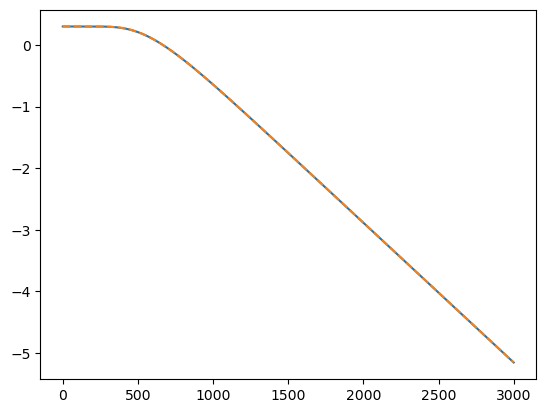

In [17]:
Ws = sparse.COO( A.nonzero(), A[A.nonzero()], fill_value=1e9)
W = 1 / (A + 1e-9) # make W very large for non-edge (i,j)

epsilon = .01*5

import time
start = time.time()
f, err, h = sinkhown_w1(Ws.todense(), z, epsilon=epsilon, niter=3000)
print('Full Sinkhorn: ' + str(time.time() - start) )

import warnings
warnings.filterwarnings('ignore')
start = time.time()
fs, errs, hs = sinkhown_w1_sparse(Ws, z, epsilon=epsilon, niter=3000)
print('Sparse Sinkhorn: ' +  str( time.time() - start) )

plt.plot(np.log10( err ))
plt.plot(np.log10( errs ), '--')

Run and displays the evolution of the error $\| f^\top 1 - f 1 - z \|_1$

Display a thresholded flow.

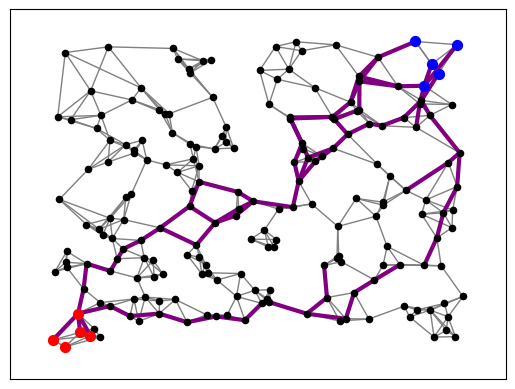

In [19]:
edges = G.edges()
nx.draw_networkx(G, pos, node_color='black', edge_color='gray', with_labels=False, node_size=20, width=1)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z>0)[0], node_color='red', node_size=50)
nx.draw_networkx_nodes(G, pos, nodelist=np.where(z<0)[0], node_color='blue', node_size=50)
edges_to_draw = [(i, j) for i in range(n) for j in range(n) if f[i, j] > f.max()/10]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='purple', width=3, node_size=0)
plt.show()